In [54]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sn, sns
import matplotlib.style as style; style.use('fivethirtyeight')
from scipy.stats import zscore, norm

# Modelling - LR, KNN, NB, Metrices

from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, roc_curve,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE

import warnings; warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

In [55]:
bank = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
bank.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [56]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


Onservation - 1 : No null values

### EDA

In [57]:
bank.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [58]:
# Checking the distribution of Target Varibale

display(bank['Personal Loan'].value_counts(), bank['Personal Loan'].value_counts(normalize = True)*100)

Personal Loan
0    4520
1     480
Name: count, dtype: int64

Personal Loan
0    90.4
1     9.6
Name: proportion, dtype: float64

--  Among 5000 customers, only 480(=9.6%) accepted the personal loan that was offered to them in earlier campaign.

In [59]:
bank.loc[bank['Experience'] < 0].describe().T

,count,mean,std,min,25%,50%,75%,max
ID,52.0,2427.346154,1478.834118,90.0,767.25,2783.5,3669.500,4958.0
Age,52.0,24.519231,1.475159,23.0,24.00,24.0,25.000,29.0
Experience,52.0,-1.442308,0.639039,-3.0,-2.00,-1.0,-1.000,-1.0
Income,52.0,69.942308,37.955295,12.0,40.75,65.5,86.750,150.0
ZIP Code,52.0,93240.961538,1611.654806,90065.0,92167.75,93060.0,94720.000,95842.0
Family,52.0,2.865385,0.970725,1.0,2.00,3.0,4.000,4.0
CCAvg,52.0,2.129423,1.750562,0.2,1.00,1.8,2.325,7.2
Education,52.0,2.076923,0.836570,1.0,1.00,2.0,3.000,3.0
Mortgage,52.0,43.596154,90.027068,0.0,0.00,0.0,0.000,314.0
Personal Loan,52.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0


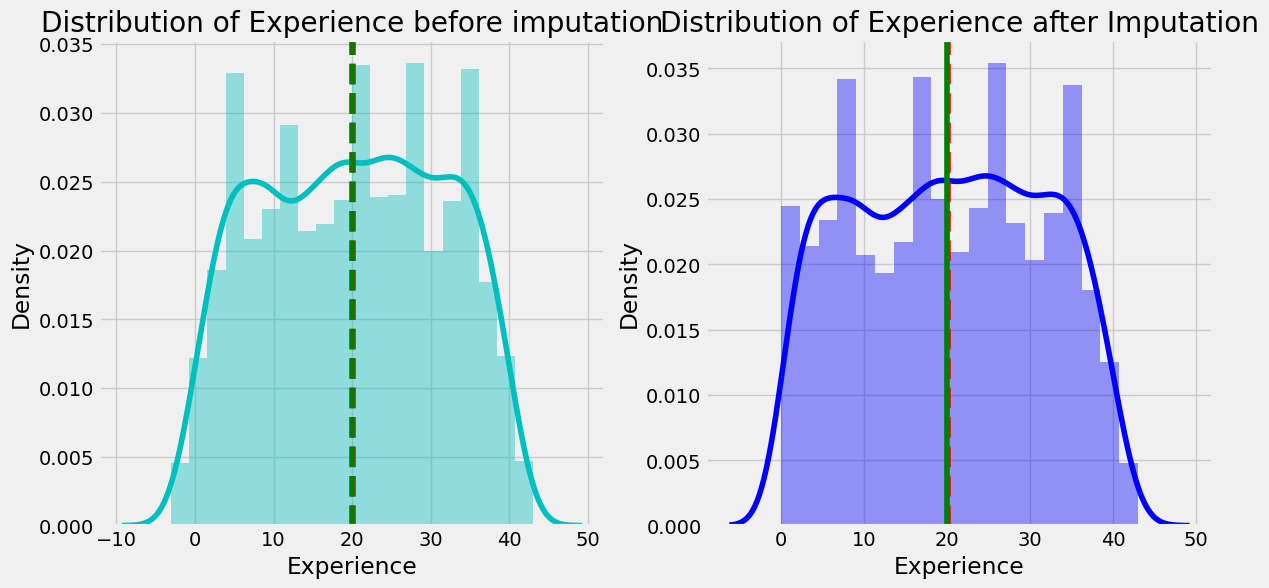

In [60]:
# Checking distribution of Experience column before and after imputation

fig = plt.figure(figsize = (12.8, 6))

ax = fig.add_subplot(121)
sn.distplot(bank['Experience'], color = 'c', ax=ax).set_title('Distribution of Experience before imputation')
ax.axvline(bank['Experience'].mean(), color = 'r', linestyle = '--', label = 'Mean')
ax.axvline(bank['Experience'].median(), color = 'g', linestyle = '--', label = 'Median')

replace_value = bank.loc[(bank['Age'] > 23) & (bank['Age'] <= 29) & (bank['Income'] > 12) & (bank['Income']>12) & (bank['Income'] < 150) &
                         (bank['Personal Loan'] == 0) & (bank['CD Account'] == 0), 'Experience'].median()

bank['Experience'] = np.where(bank['Experience'] < 0, replace_value, bank['Experience'])


ax = fig.add_subplot(122)
sn.distplot(bank['Experience'], color = 'b', ax = ax).set_title('Distribution of Experience after Imputation')
ax.axvline(bank['Experience'].mean(), color = 'r', linestyle = '--', label = 'Mean')
ax.axvline(bank['Experience'].median(), color = 'g', linestyle = '-', label = 'Median')

Text(0.5, 1.0, 'Distribution of Mortgage for taking Personal Loan')

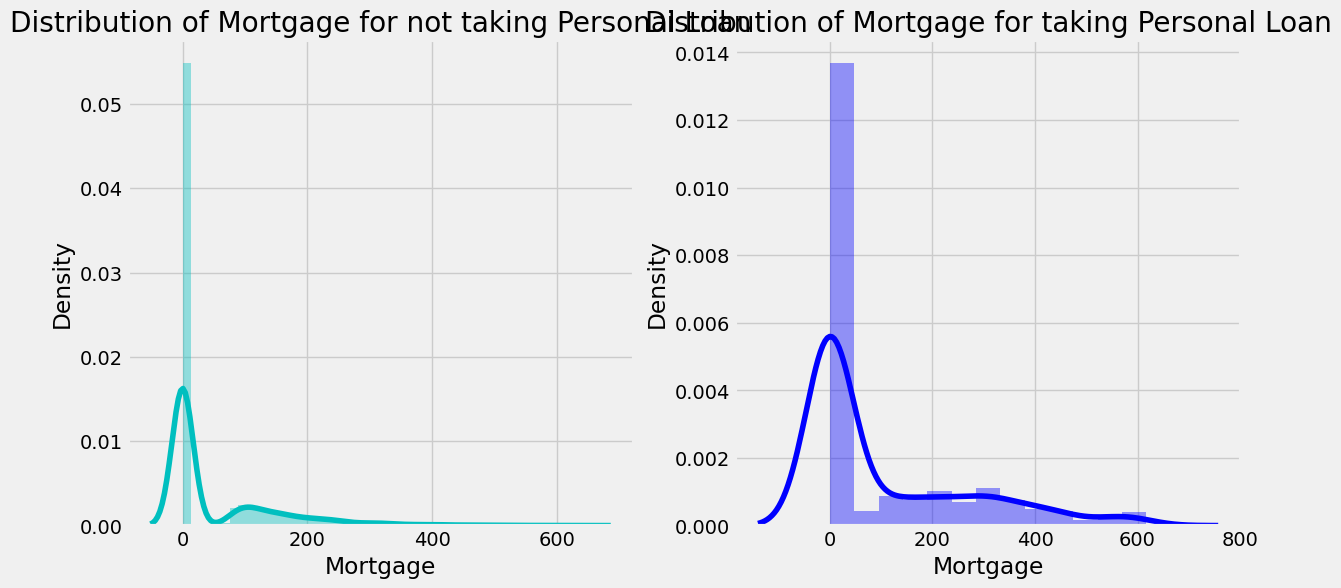

In [61]:
# Distribution of Mortgage
fig = plt.figure(figsize = (12.8, 6))

ax = fig.add_subplot(121)
sn.distplot(bank[(bank['Personal Loan'] == 0)]['Mortgage'], color = 'c', 
             ax = ax).set_title('Distribution of Mortgage for not taking Personal Loan')

ax= fig.add_subplot(122)
sn.distplot(bank[(bank['Personal Loan'] == 1)]['Mortgage'], color = 'b', 
             ax = ax).set_title('Distribution of Mortgage for taking Personal Loan')

Text(0.5, 1.0, 'Distribution of CCAvg for taking Personal Loan')

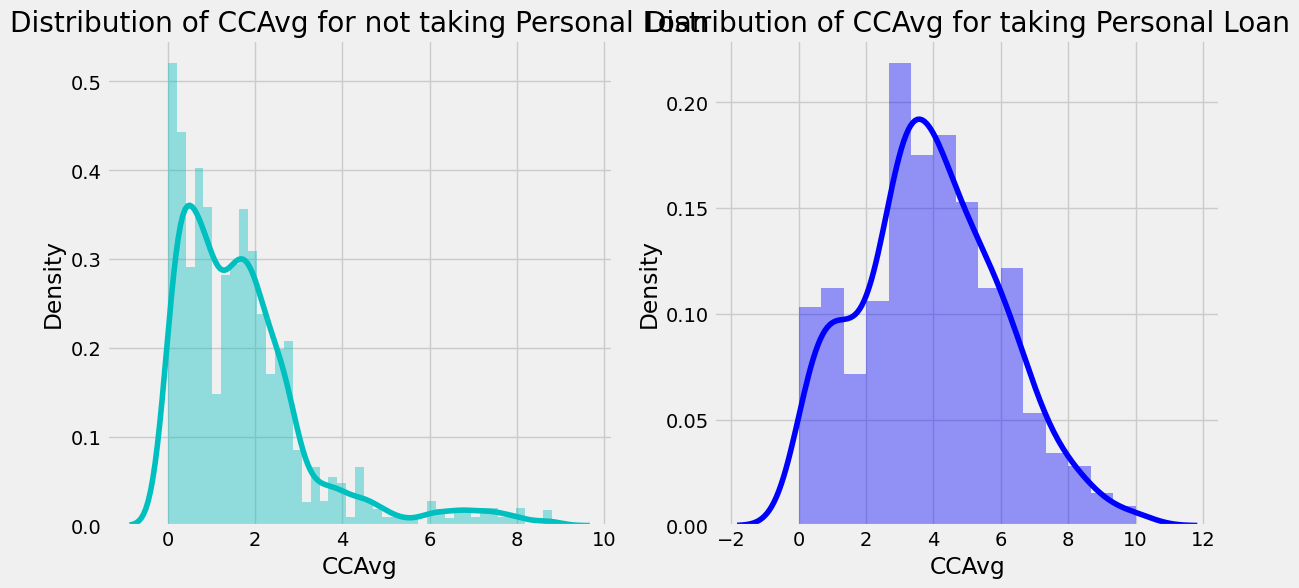

In [62]:
# Distribution of CCAvg

# Distribution of CCAvg
fig = plt.figure(figsize = (12.8, 6))

ax = fig.add_subplot(121)
sn.distplot(bank[(bank['Personal Loan'] == 0)]['CCAvg'], color = 'c', 
             ax = ax).set_title('Distribution of CCAvg for not taking Personal Loan')

ax= fig.add_subplot(122)
sn.distplot(bank[(bank['Personal Loan'] == 1)]['CCAvg'], color = 'b', 
             ax = ax).set_title('Distribution of CCAvg for taking Personal Loan')


Text(0.5, 1.0, 'Distribution of Income for taking Personal Loan')

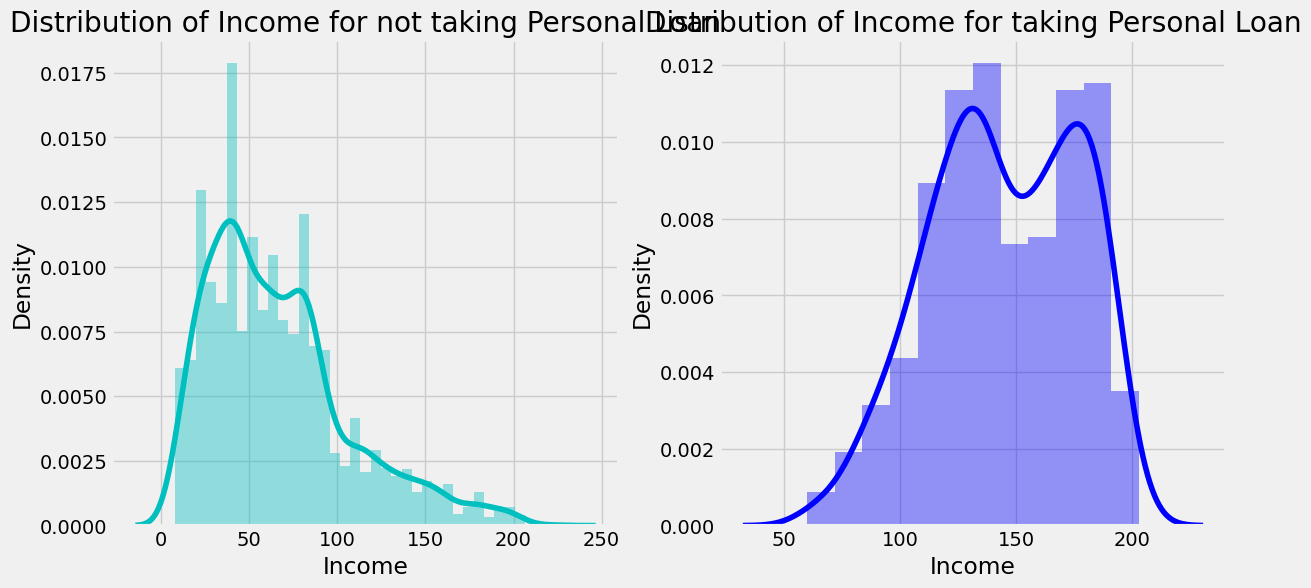

In [63]:
# Distribution of Income
fig = plt.figure(figsize = (12.8, 6))

ax = fig.add_subplot(121)
sn.distplot(bank[(bank['Personal Loan'] == 0)]['Income'], color = 'c', 
             ax = ax).set_title('Distribution of Income for not taking Personal Loan')

ax= fig.add_subplot(122)
sn.distplot(bank[(bank['Personal Loan'] == 1)]['Income'], color = 'b', 
             ax = ax).set_title('Distribution of Income for taking Personal Loan')

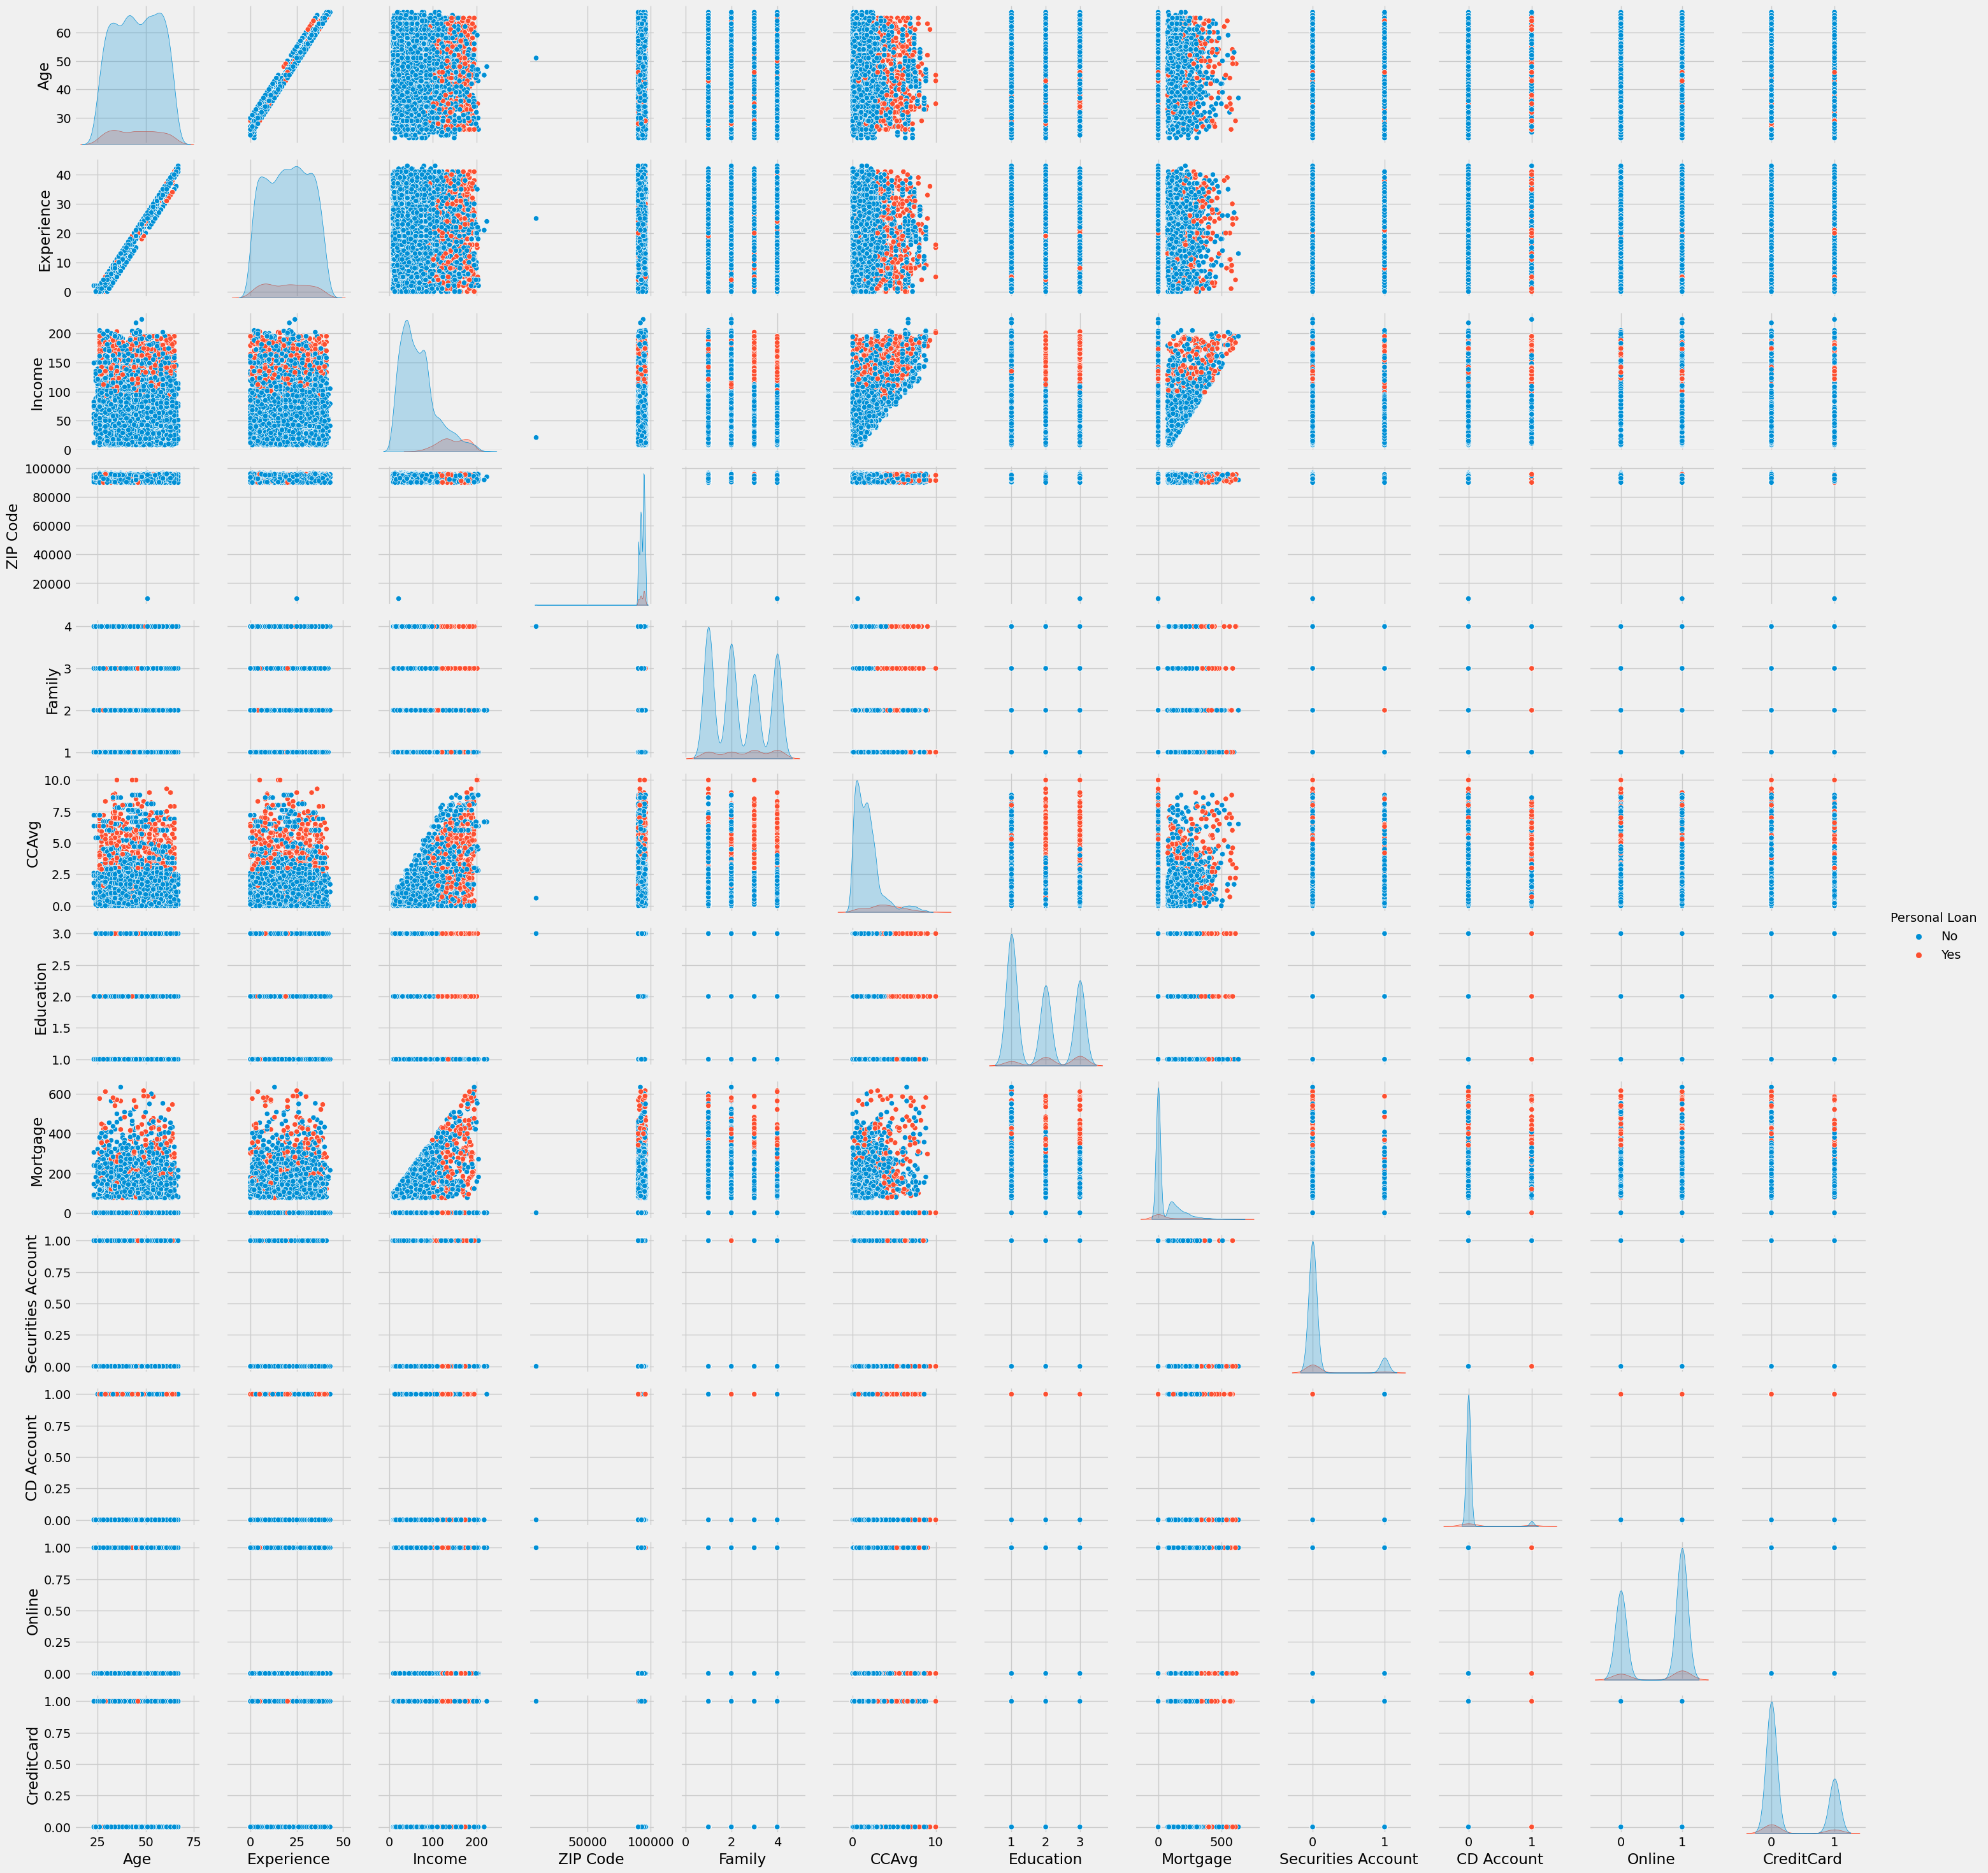

In [64]:
# Pairplot

pairplt = bank.drop('ID',axis = 1)
pairplt['Personal Loan'] = pairplt['Personal Loan'].replace({0: 'No', 1: 'Yes'})
sn.pairplot(pairplt, hue = 'Personal Loan')

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
384,385,51,25.0,21,9307,4,0.6,3,0,0,0,0,1,1


Text(0.5, 1.0, 'Outlier in Zip Code')

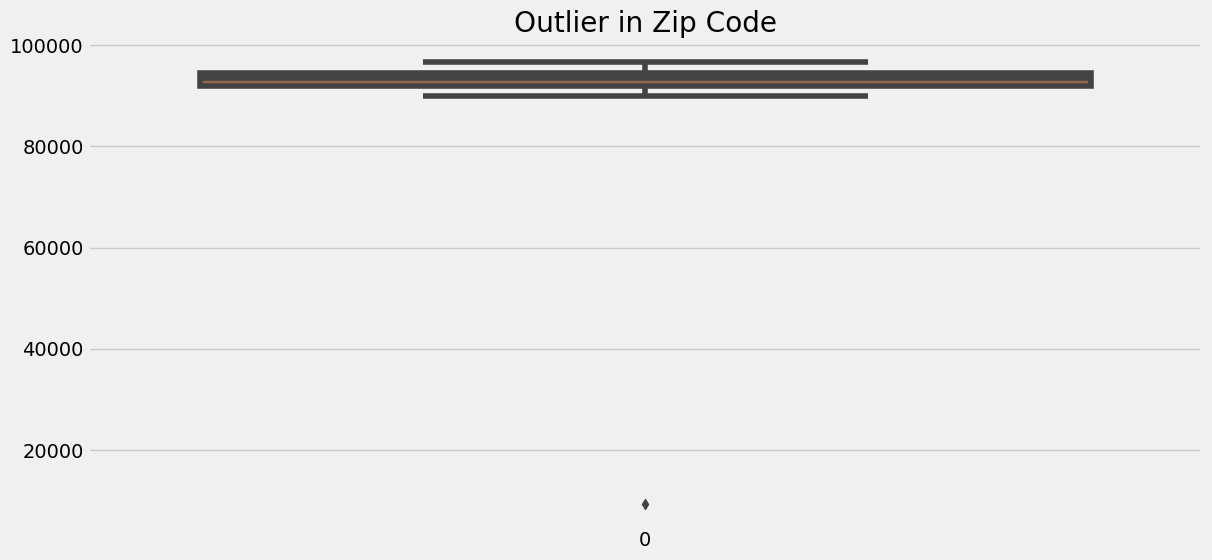

In [65]:
# Checking outlier in ZIP CODE

display(bank[bank['ZIP Code'] < 10000])
plt.figure(figsize = (12.8 , 6))
sn.boxplot(bank['ZIP Code'], palette = 'copper').set_title('Outlier in Zip Code')

In [66]:
bank.drop(384, axis = 0, inplace = True)

Text(0.5, 1.0, 'Distribution of Income by Personal Loan')

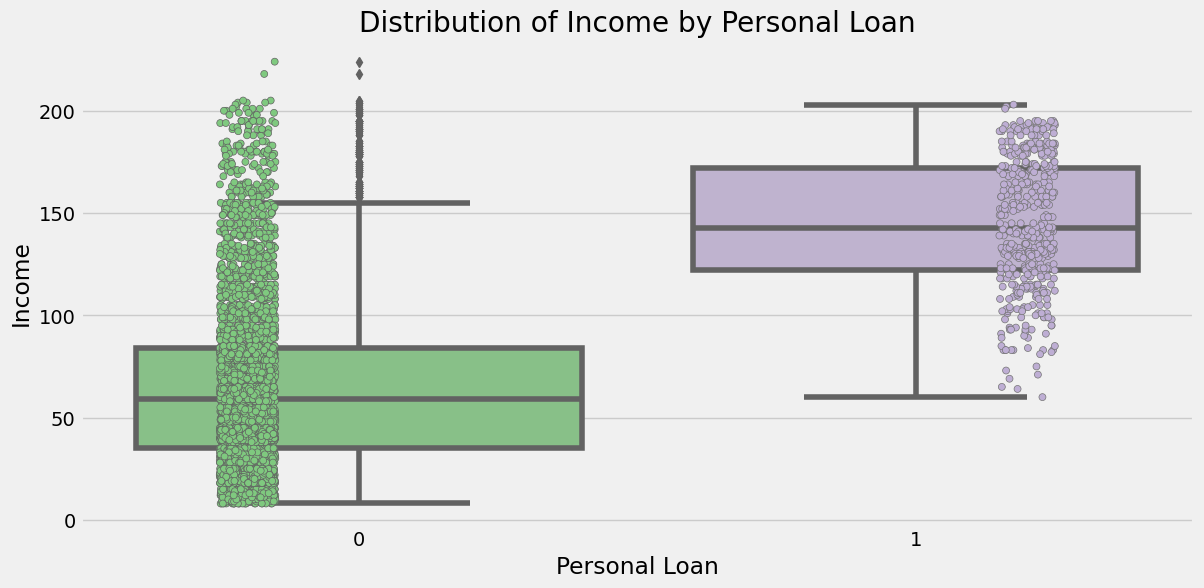

In [67]:
# Distribution of Income by Personal Loan
plt.figure(figsize = (12.8 , 6))
ax = sn.boxplot(x = 'Personal Loan', y = 'Income', palette = 'Accent', data = bank)
ax = sn.stripplot(x = 'Personal Loan', y = 'Income', palette = 'Accent', data = bank, 
              jitter = True, dodge = True, linewidth = 0.5)
ax.set_title('Distribution of Income by Personal Loan')

<Figure size 1280x600 with 0 Axes>

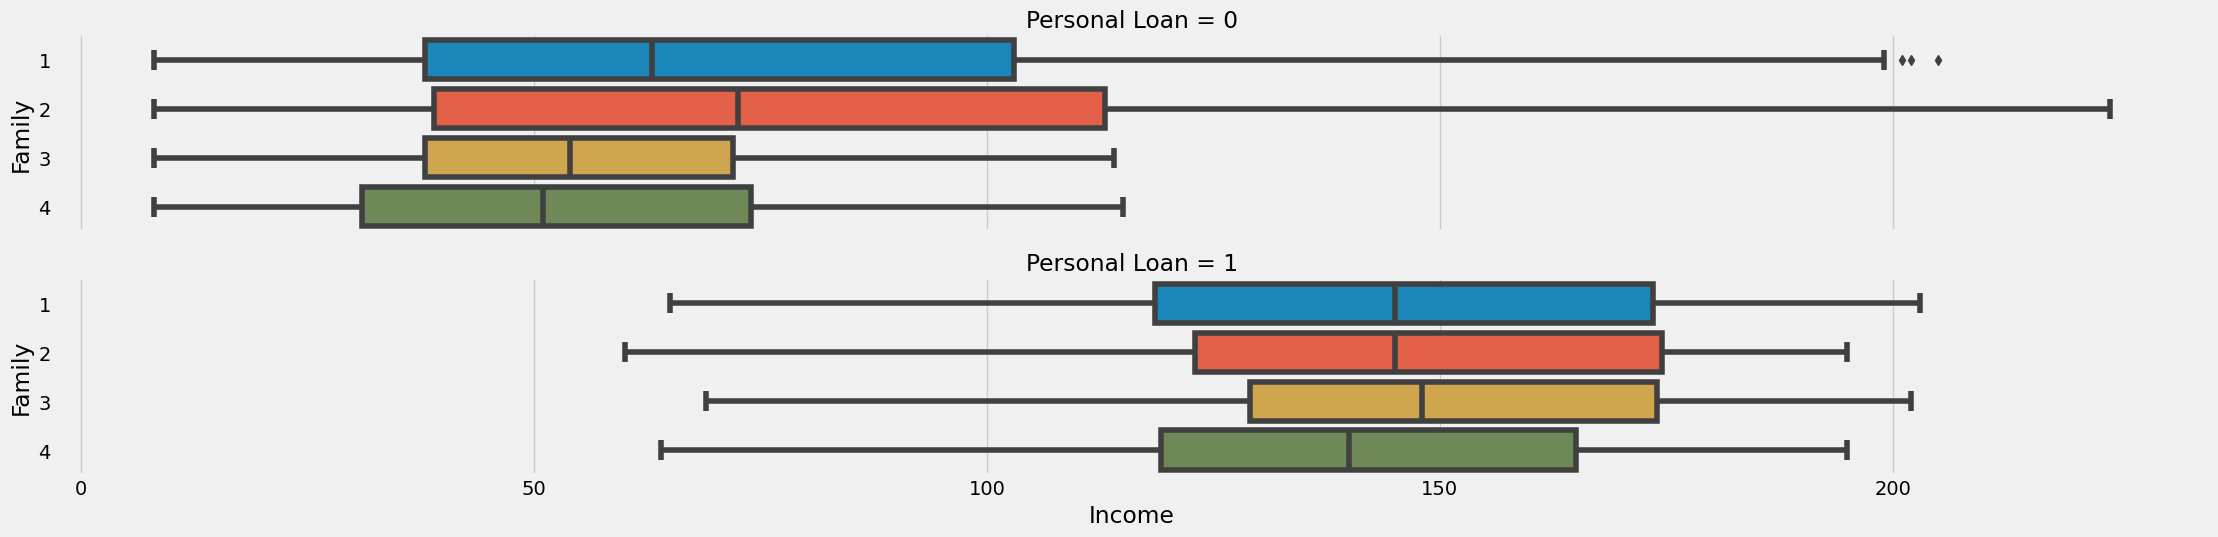

In [68]:
# Distribution of Family Size by Personal Loan and affect of Income
plt.figure(figsize = (12.8 , 6))
sn.catplot(x = 'Income', y = 'Family', row = 'Personal Loan', kind = 'box', orient = 'h', height = 2.8, aspect = 8, 
            data = bank)

<Figure size 1280x600 with 0 Axes>

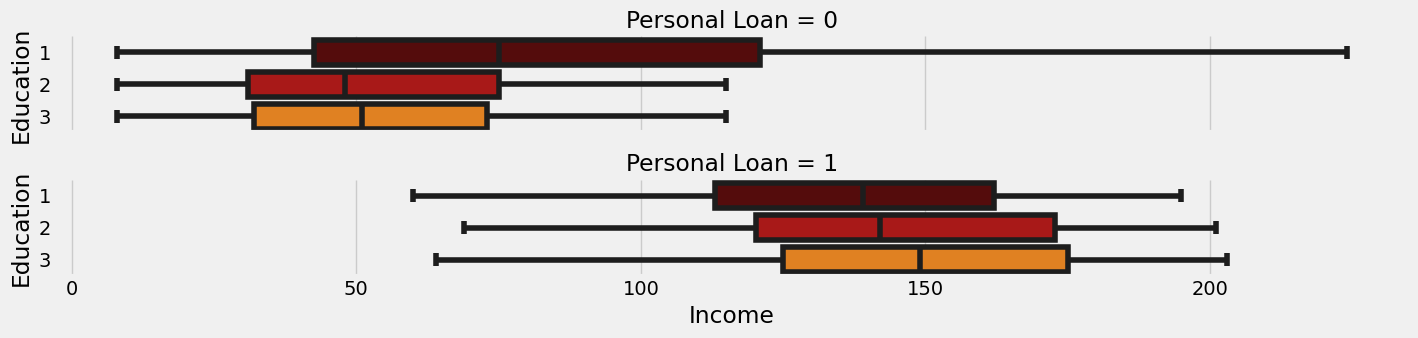

In [69]:
# Distribution of Education by Personal Loan and affect of Income
plt.figure(figsize = (12.8 , 6))
sn.catplot(x = 'Income', y = 'Education', row = 'Personal Loan', kind = 'box', orient = 'h', 
            height = 1.8, aspect = 8, palette = 'gist_heat', data = bank)

<Axes: xlabel='Education', ylabel='count'>

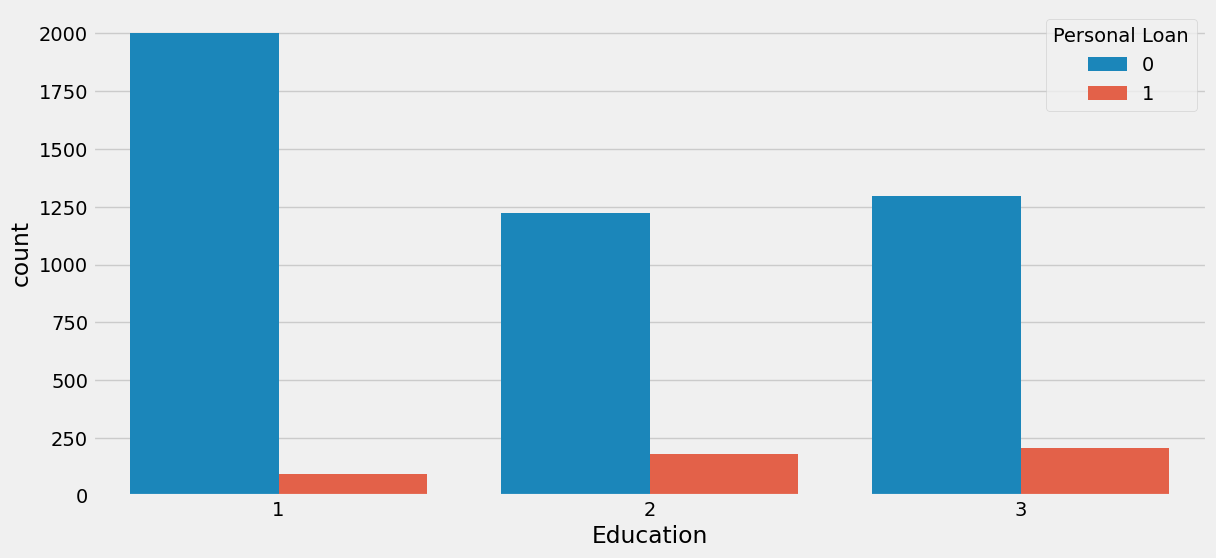

In [70]:
# Countplot of Education by Personal Loan
plt.figure(figsize = (12.8 , 6))
sn.countplot(x = 'Education', hue ='Personal Loan', data = bank)

<Axes: xlabel='CD Account', ylabel='count'>

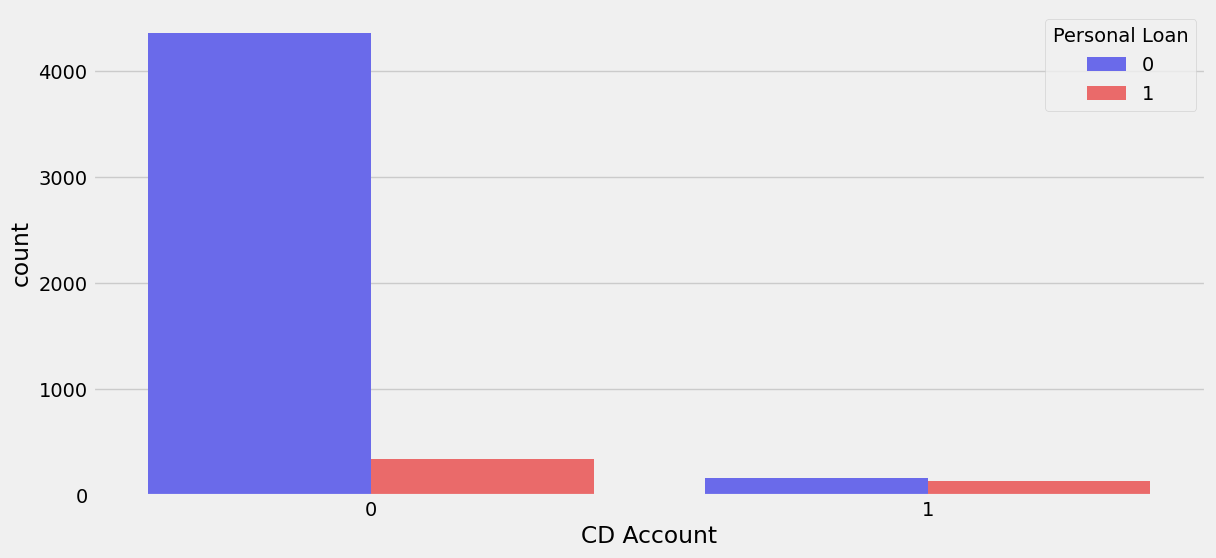

In [71]:
# Countplot of CD Account by Personal Loan
plt.figure(figsize = (12.8 , 6))
sn.countplot(x = 'CD Account', hue ='Personal Loan', palette = 'seismic', data = bank)

In [72]:
# Checking unique values

cat_cols = ['ZIP Code', 'Family', 'Education', 'Personal Loan','Securities Account', 'CD Account', 'Online', 'CreditCard']
bank[cat_cols].nunique()

ZIP Code              466
Family                  4
Education               3
Personal Loan           2
Securities Account      2
CD Account              2
Online                  2
CreditCard              2
dtype: int64

In [73]:
bank.drop(['ID','ZIP Code'], axis = 1, inplace = True)
bank.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account',
       'Online', 'CreditCard'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Matrix of Data')

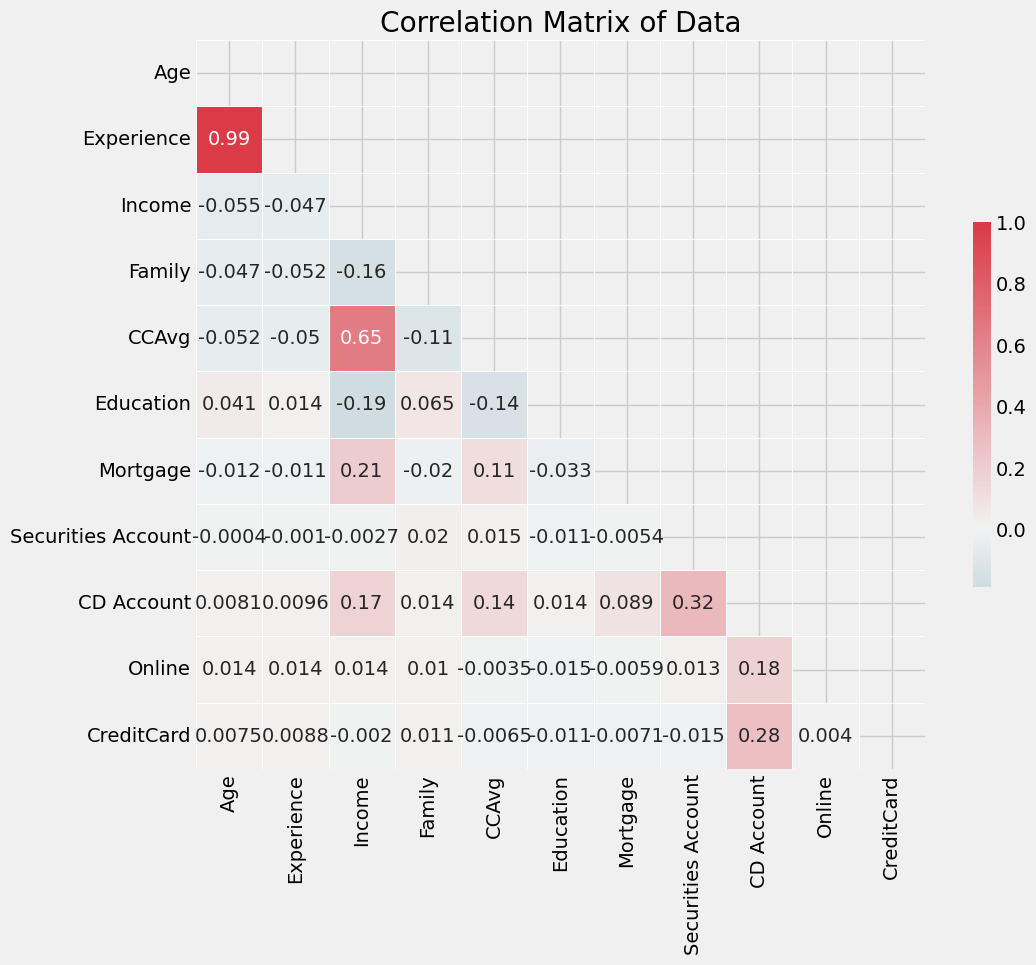

In [74]:
# Correlation matrix for all variables
corr = bank.drop('Personal Loan', axis = 1).corr()

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

cmap = sn.diverging_palette(220, 10, as_cmap = True)

sn.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, 
            linewidths = .5, cbar_kws = {"shrink": .5}, annot = True)
ax.set_title('Correlation Matrix of Data')

In [75]:
# Filrting the correlation value greater than 0.5

sort = corr.abs().unstack()
sort = sort.sort_values(kind = "quicksort", ascending = False)
sort[(sort > 0.5) & (sort < 1)]

Experience  Age           0.993922
Age         Experience    0.993922
Income      CCAvg         0.645931
CCAvg       Income        0.645931
dtype: float64

In [76]:
# Correlation of independent varibales with Personal Loan

absCorrwithDep = []
allVars = bank.drop('Personal Loan', axis = 1).columns

for var in allVars:
    absCorrwithDep.append([abs(bank['Personal Loan'].corr(bank[var]))])

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable','Correlation']).T.\
        sort_values('Correlation', ascending = False))

,Variable,Correlation
2,Income,[0.5024589564435594]
4,CCAvg,[0.36686423211476]
8,CD Account,[0.3163436956330295]
6,Mortgage,[0.14206491686580763]
5,Education,[0.13683416735201487]
3,Family,[0.06147079893719664]
7,Securities Account,[0.02193211414804671]
1,Experience,[0.00844902087241519]
0,Age,[0.007693687351102688]
9,Online,[0.006331891939707545]


### Modelling

In [77]:
bank.drop(['Age','Online','CreditCard'], axis = 1, inplace = True)
bank.columns

Index(['Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage',
       'Personal Loan', 'Securities Account', 'CD Account'],
      dtype='object')

In [81]:
X = bank.drop(['Personal Loan'], axis = 1)
y = bank['Personal Loan']

display(X.describe().T, X.shape, y.shape)


,count,mean,std,min,25%,50%,75%,max
Experience,4999.0,20.139428,11.406577,0.0,10.0,20.0,30.0,43.0
Income,4999.0,73.784757,46.032281,8.0,39.0,64.0,98.0,224.0
Family,4999.0,2.396079,1.147554,1.0,1.0,2.0,3.0,4.0
CCAvg,4999.0,1.938206,1.747731,0.0,0.7,1.5,2.5,10.0
Education,4999.0,1.880776,0.839804,1.0,1.0,2.0,3.0,3.0
Mortgage,4999.0,56.510102,101.720837,0.0,0.0,0.0,101.0,635.0
Securities Account,4999.0,0.104421,0.305836,0.0,0.0,0.0,0.0,1.0
CD Account,4999.0,0.060412,0.238273,0.0,0.0,0.0,0.0,1.0


(4999, 8)

(4999,)

### Logistic Regression

In [82]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)
display(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3499, 8)

(1500, 8)

(3499,)

(1500,)

LR model without Hyperparameter Tuning

LR scores without Hyperparameter Tuning 


LR accuracy for train set: 0.951
LR accuracy for train set: 0.943

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1354
           1       0.80      0.56      0.66       146

    accuracy                           0.94      1500
   macro avg       0.88      0.77      0.81      1500
weighted avg       0.94      0.94      0.94      1500


 COnfusion Matrix: 
 [[1333   21]
 [  64   82]]

 Accuracy Score:
 0.943


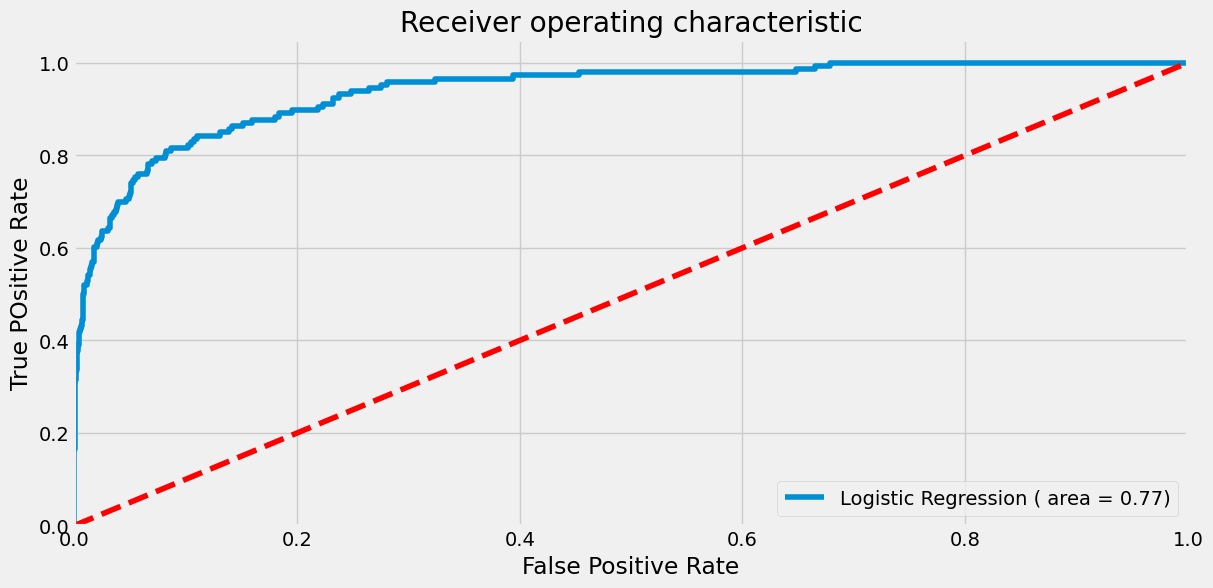

In [89]:
LR = LogisticRegression()
LR.fit(x_train,y_train)

# Scores

print("LR scores without Hyperparameter Tuning \n\n")
print('LR accuracy for train set: {0:.3f}'.format(LR.score(x_train,y_train)))
print('LR accuracy for train set: {0:.3f}'.format(LR.score(x_test,y_test)))

y_true, y_pred = y_test, LR.predict(x_test)

# Classification report

print('\n{}'.format(classification_report(y_true,y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\n COnfusion Matrix: \n', cm)

# Accuracy Score

auc = accuracy_score(y_true, y_pred)
print('\n Accuracy Score:\n', auc.round(3))

# ROC Curve

LR_roc_auc = roc_auc_score(y_true, LR.predict(x_test))
fpr, tpr, threshols = roc_curve(y_true, LR.predict_proba(x_test)[:,1])
plt.figure(figsize = (12.8,6))
plt.plot(fpr,tpr, label = 'Logistic Regression ( area = {})'.\
         format(LR_roc_auc.round(2)))
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True POsitive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = 'lower right')
plt.show()



Logistic Regression Scores with Hyperparameter Tuning


Best Hyper Parameters are:  {'C': 100, 'max_iter': 140, 'penalty': 'l2'}
Best Score is:  0.952
LR accuracy for train set: 0.951
LR accuracy for test set: 0.943

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1354
           1       0.78      0.58      0.66       146

    accuracy                           0.94      1500
   macro avg       0.87      0.78      0.82      1500
weighted avg       0.94      0.94      0.94      1500


Confusion Matrix:
 [[1330   24]
 [  62   84]]

Accuracy Score:
 0.943


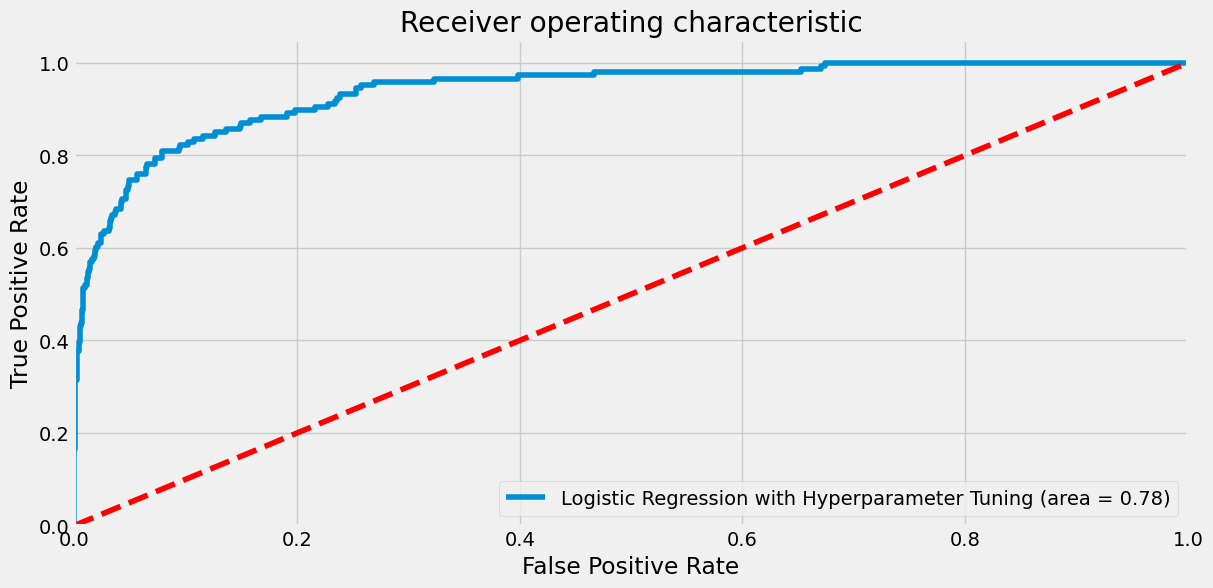

In [99]:
# LR with hyperparameter tuning

LR = LogisticRegression(random_state=42)

params = {'penalty' : [ 'l1', 'l2'], 'C': [0.001, 0.01, 1, 10, 100], 'max_iter': [100,110,120,130,140]}
skf = StratifiedKFold(n_splits = 10)
LR_hyper = GridSearchCV(LR, param_grid= params, n_jobs = -1,cv = skf)
LR_hyper.fit (x_train, y_train)

print('Logistic Regression Scores with Hyperparameter Tuning\n\n')
print('Best Hyper Parameters are: ', LR_hyper.best_params_)
print('Best Score is: ', LR_hyper.best_score_.round(3))

print('LR accuracy for train set: {0:.3f}'.format(LR_hyper.score(x_train, y_train)))
print('LR accuracy for test set: {0:.3f}'.format(LR_hyper.score(x_test, y_test)))

y_true, y_pred = y_test, LR_hyper.predict(x_test)

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)


# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# ROC Curve
LR_hyper_roc_auc = roc_auc_score(y_true, LR_hyper.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_true, LR_hyper.predict_proba(x_test)[:,1])
plt.figure(figsize = (12.8 , 6))
plt.plot(fpr, tpr, label = 'Logistic Regression with Hyperparameter Tuning (area = {})'.\
         format(LR_hyper_roc_auc.round(2)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = 'lower right')
plt.show()


### K-Nearest Classifier

In [100]:
# Splitting the data into training and test set in the ratio of 70:30 respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3499, 8)

(1500, 8)

(3499,)

(1500,)

k-Nearest Neighbor Classifier Scores without feature scaling


k-NN accuracy for train set: 0.941
k-NN accuracy for test set: 0.907

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1354
           1       0.54      0.30      0.39       146

    accuracy                           0.91      1500
   macro avg       0.74      0.64      0.67      1500
weighted avg       0.89      0.91      0.90      1500


Accuracy Score:
 0.907


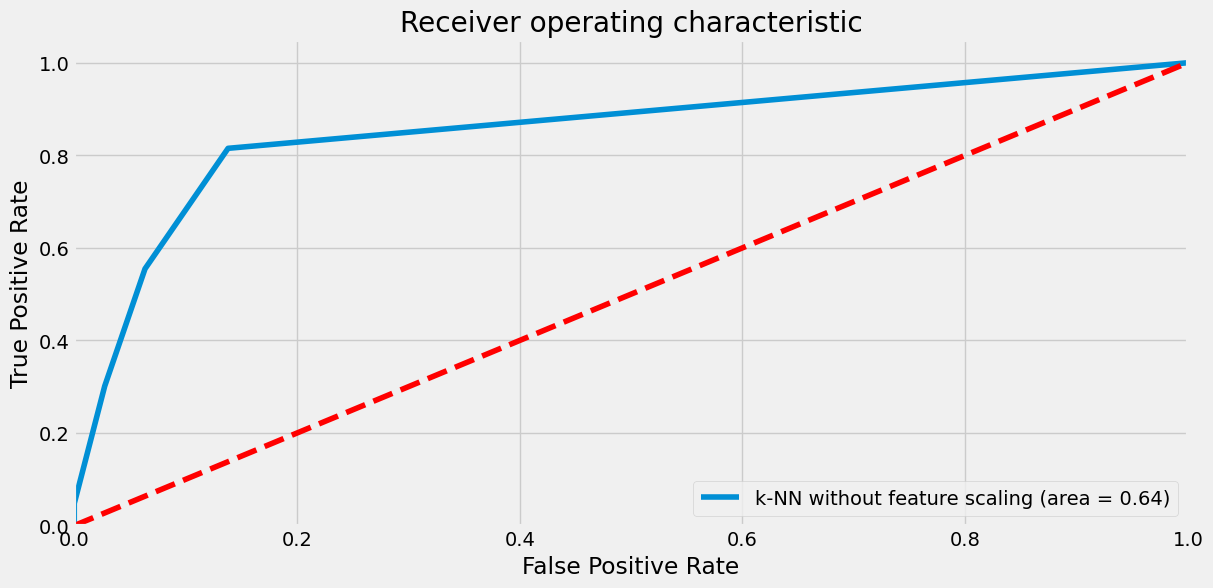

In [105]:
# KNN Model without scaling the features

KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)

print('k-Nearest Neighbor Classifier Scores without feature scaling\n\n')
print('k-NN accuracy for train set: {0:.3f}'.format(KNN.score(X_train, y_train)))
print('k-NN accuracy for test set: {0:.3f}'.format(KNN.score(X_test, y_test)))

y_true, y_pred = y_test, KNN.predict(x_test)

print('\n{}'.format(classification_report(y_true, y_pred)))

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))


KNN_roc_auc = roc_auc_score(y_true, KNN.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_true, KNN.predict_proba(X_test)[:,1])
plt.figure(figsize = (12.8 , 6))
plt.plot(fpr, tpr, label = 'k-NN without feature scaling (area = {})'.\
         format(KNN_roc_auc.round(2)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = 'lower right')
plt.show()

In [107]:
# Scaling the independent variables

Xs = X.apply(zscore)
display(Xs.describe().T, Xs.shape, y.shape)

,count,mean,std,min,25%,50%,75%,max
Experience,4999.0,-1.371622e-16,1.0001,-1.765774,-0.889000,-0.012225,0.864550,2.004358
Income,4999.0,-8.528218e-18,1.0001,-1.429243,-0.755736,-0.212584,0.526102,3.263585
Family,4999.0,1.208164e-16,1.0001,-1.216692,-1.216692,-0.345185,0.526321,1.397827
CCAvg,4999.0,3.269150e-17,1.0001,-1.109095,-0.708535,-0.250753,0.321474,4.613181
Education,4999.0,-1.222378e-16,1.0001,-1.048893,-1.048893,0.141980,1.332854,1.332854
Mortgage,4999.0,-2.416329e-17,1.0001,-0.555597,-0.555597,-0.555597,0.437416,5.687603
Securities Account,4999.0,5.685479e-18,1.0001,-0.341461,-0.341461,-0.341461,-0.341461,2.928588
CD Account,4999.0,-5.756547e-17,1.0001,-0.253567,-0.253567,-0.253567,-0.253567,3.943727


(4999, 8)

(4999,)

In [108]:
# Splitting the data into training and test set in the ratio of 70:30 respectively
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size = 0.3, random_state = 42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3499, 8)

(1500, 8)

(3499,)

(1500,)

k-Nearest Neighbor Classifier Scores after Scaling without Hyperparameter Tuning


k-NN accuracy for train set: 0.976
k-NN accuracy for test set: 0.961

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1354
           1       0.95      0.63      0.76       146

    accuracy                           0.96      1500
   macro avg       0.95      0.81      0.87      1500
weighted avg       0.96      0.96      0.96      1500


Confusion Matrix:
 [[1349    5]
 [  54   92]]

Accuracy Score:
 0.961


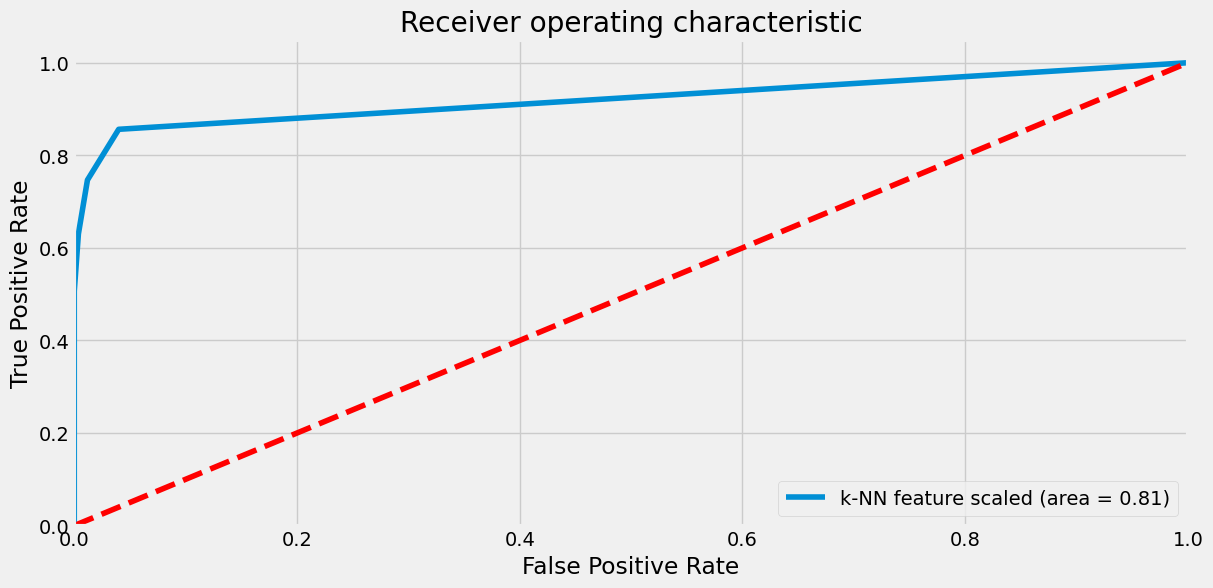

In [109]:
# KNN model after scaling without hyperparameter tuning

KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

print('k-Nearest Neighbor Classifier Scores after Scaling without Hyperparameter Tuning\n\n')
print('k-NN accuracy for train set: {0:.3f}'.format(KNN.score(X_train, y_train)))
print('k-NN accuracy for test set: {0:.3f}'.format(KNN.score(X_test, y_test)))

y_true, y_pred = y_test, KNN.predict(X_test)

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# ROC Curve
KNN_roc_auc = roc_auc_score(y_true, KNN.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_true, KNN.predict_proba(X_test)[:,1])
plt.figure(figsize = (12.8 , 6))
plt.plot(fpr, tpr, label = 'k-NN feature scaled (area = {})'.\
         format(KNN_roc_auc.round(2)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = 'lower right')
plt.show()

k-Nearest Neighbor Classifier Scores after Hyperparameter Tuning


Best Hyper Parameters are:  {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}

Best Score is:  0.97
k-NN accuracy for train set: 1.000
k-NN accuracy for test set: 0.964

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1354
           1       0.97      0.65      0.78       146

    accuracy                           0.96      1500
   macro avg       0.97      0.82      0.88      1500
weighted avg       0.96      0.96      0.96      1500


Confusion Matrix:
 [[1351    3]
 [  51   95]]

Accuracy Score:
 0.964


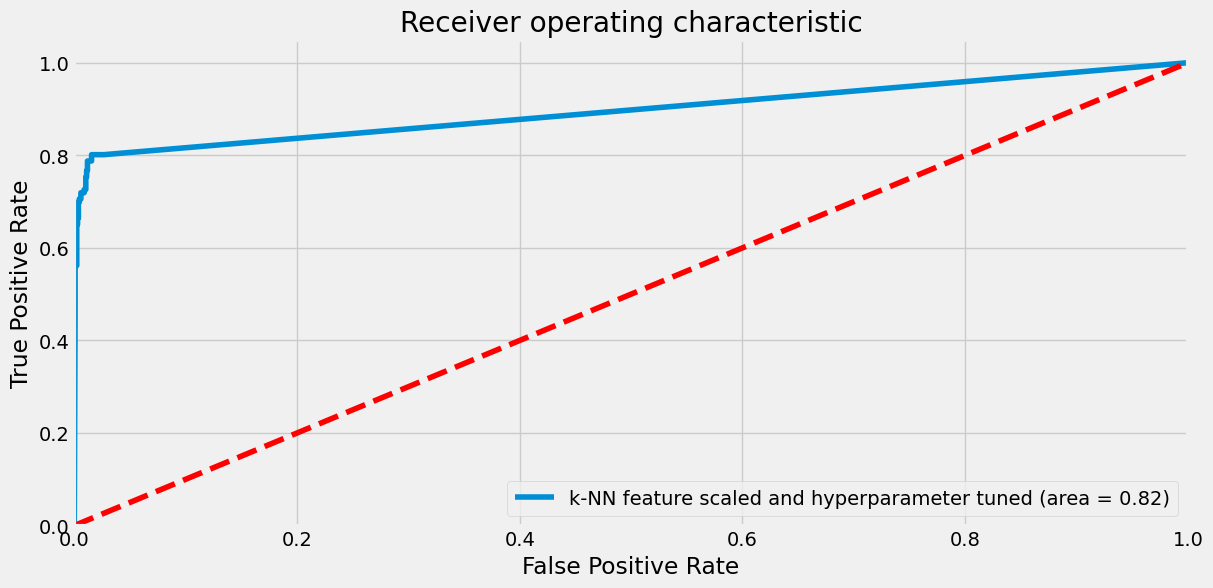

In [116]:
# KNN with hyperparameter tuning

KNN = KNeighborsClassifier(n_jobs = -1)

params = {'n_neighbors': list(range(1, 40, 2)), 'weights': ['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle= True)
KNN_hyper = GridSearchCV(KNN, param_grid = params, n_jobs = -1, cv = skf)

KNN_hyper.fit(X_train, y_train)

print('k-Nearest Neighbor Classifier Scores after Hyperparameter Tuning\n\n')
print('Best Hyper Parameters are: ', KNN_hyper.best_params_)
print('\nBest Score is: ', KNN_hyper.best_score_.round(3))

print('k-NN accuracy for train set: {0:.3f}'.format(KNN_hyper.score(X_train, y_train)))
print('k-NN accuracy for test set: {0:.3f}'.format(KNN_hyper.score(X_test, y_test)))

y_true, y_pred = y_test, KNN_hyper.predict(X_test)

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# ROC Curve
KNN_hyper_roc_auc = roc_auc_score(y_true, KNN_hyper.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_true, KNN_hyper.predict_proba(X_test)[:,1])
plt.figure(figsize = (12.8 , 6))
plt.plot(fpr, tpr, label = 'k-NN feature scaled and hyperparameter tuned (area = {})'.\
         format(KNN_hyper_roc_auc.round(2)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = 'lower right')
plt.show()

### Naive Bayes Classifier

Naive Bayes Classifier Scores


NB accuracy for train set: 0.883
NB accuracy for test set: 0.893

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1354
           1       0.46      0.59      0.52       146

    accuracy                           0.89      1500
   macro avg       0.71      0.76      0.73      1500
weighted avg       0.91      0.89      0.90      1500


Confusion Matrix:
 [[1253  101]
 [  60   86]]

Accuracy Score:
 0.893


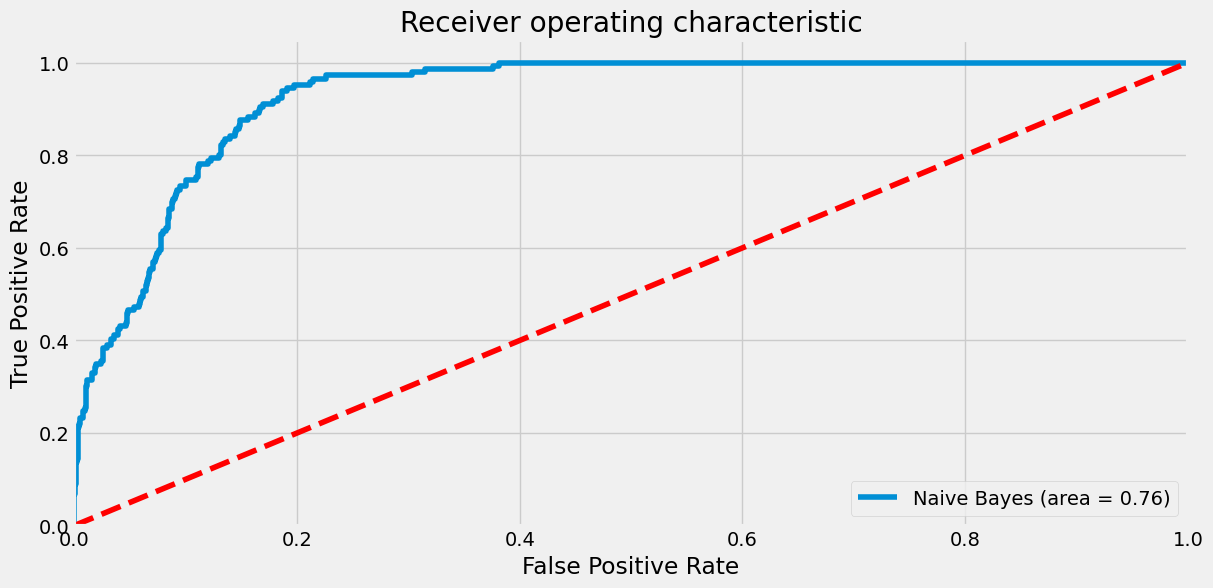

In [117]:
# Naive Bayes Model
NB = GaussianNB()
NB.fit(X_train, y_train)

print('Naive Bayes Classifier Scores\n\n')
print('NB accuracy for train set: {0:.3f}'.format(NB.score(X_train, y_train)))
print('NB accuracy for test set: {0:.3f}'.format(NB.score(X_test, y_test)))

y_true, y_pred = y_test, NB.predict(X_test)

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# ROC Curve
NB_roc_auc = roc_auc_score(y_true, NB.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_true, NB.predict_proba(X_test)[:,1])
plt.figure(figsize = (12.8 , 6))
plt.plot(fpr, tpr, label = 'Naive Bayes (area = {})'.\
         format(NB_roc_auc.round(2)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = 'lower right')
plt.show()

### Oversampling and K-NN

In [118]:
# Splitting the data into training and test set in the ratio of 70:30 respectively
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size = 0.3, random_state = 42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3499, 8)

(1500, 8)

(3499,)

(1500,)

In [121]:
sm = SMOTE(random_state = 42, sampling_strategy='minority')
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Before oversampling
unique, counts = np.unique(y_train, return_counts = True)
print(np.asarray((unique, counts)).T)

# After oversampling
unique, counts = np.unique(y_train_res, return_counts = True)
print(np.asarray((unique, counts)).T)


[[   0 3165]
 [   1  334]]
[[   0 3165]
 [   1 3165]]


k-Nearest Neighbor Classifier Scores With Oversampling (SMOTE) and Hyperparameter Tuning


Best Hyper Parameters are:  {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}

Best Score is:  0.993
k-NN accuracy for train set: 1.000
k-NN accuracy for test set: 0.970

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1354
           1       0.93      0.75      0.83       146

    accuracy                           0.97      1500
   macro avg       0.95      0.87      0.91      1500
weighted avg       0.97      0.97      0.97      1500


Confusion Matrix:
 [[1346    8]
 [  37  109]]

Accuracy Score:
 0.97


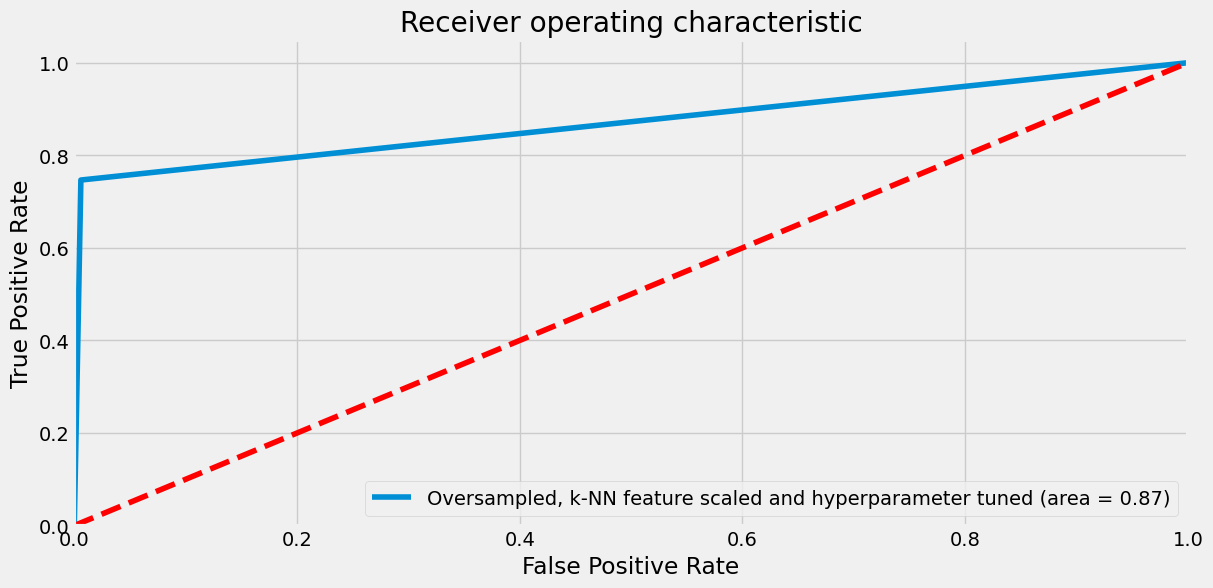

In [123]:
# KNN with hyperparameter tuning and Oversampling
KNN = KNeighborsClassifier(n_jobs = -1)

params = {'n_neighbors': list(range(1, 40, 2)), 'weights': ['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
KNN_hyper = GridSearchCV(KNN, param_grid = params, n_jobs = -1, cv = skf)

KNN_hyper.fit(X_train_res, y_train_res)

print('k-Nearest Neighbor Classifier Scores With Oversampling (SMOTE) and Hyperparameter Tuning\n\n')
print('Best Hyper Parameters are: ', KNN_hyper.best_params_)
print('\nBest Score is: ', KNN_hyper.best_score_.round(3))

print('k-NN accuracy for train set: {0:.3f}'.format(KNN_hyper.score(X_train_res, y_train_res)))
print('k-NN accuracy for test set: {0:.3f}'.format(KNN_hyper.score(X_test, y_test)))

y_true, y_pred = y_test, KNN_hyper.predict(X_test)

# Classification Report
print('\n{}'.format(classification_report(y_true, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('\nConfusion Matrix:\n', cm)

# Accuracy Score
auc = accuracy_score(y_true, y_pred)
print('\nAccuracy Score:\n', auc.round(3))

# ROC Curve
KNN_hyper_roc_auc = roc_auc_score(y_true, KNN_hyper.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_true, KNN_hyper.predict_proba(X_test)[:,1])
plt.figure(figsize = (12.8 , 6))
plt.plot(fpr, tpr, label = 'Oversampled, k-NN feature scaled and hyperparameter tuned (area = {})'.\
         format(KNN_hyper_roc_auc.round(2)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = 'lower right')
plt.show()